In [41]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])

### MSE

In [4]:
mse_to_target_map = {"CURE": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}, 
         "adv_train_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
         "standard": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
         "standard_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}}

for method in ["CURE", "adv_train_RN50", "standard", "standard_RN50"]:
    for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-2].startswith("LPIPS:"):
                    for l in lines[::-1]:
                        if l.startswith("Final MSE:"):
                            mse_to_target_map[method][att].append(float(l.strip().split(" ")[-1]))
                            break

FileNotFoundError: [Errno 2] No such file or directory: '../ad-hoc_results/CURE/add/'

### LPIPS

In [5]:
lpips_to_original_image = {"CURE": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}, 
         "adv_train_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
          "standard": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
          "standard_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}}

for method in ["CURE", "adv_train_RN50", "standard", "standard_RN50"]:
    for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-2].startswith("LPIPS:"):
                    lpips_to_original_image[method][att].append(float(lines[-2].strip().split(" ")[-1]))
                        

In [6]:
len(mse_to_target_map["standard_RN50"]["add"])

25

### viz

In [7]:
errors = {}
for k, v in mse_to_target_map.items():
    errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

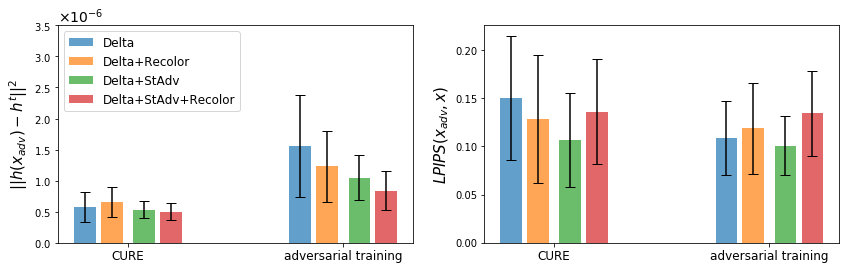

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2])
ax[0].bar(x_s - 0.2, 
           [np.mean(mse_to_target_map["CURE"]["add"]), 
            np.mean(mse_to_target_map["adv_train_RN50"]["add"])], 
            yerr=[errors["CURE"]["add"], errors["adv_train_RN50"]["add"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s - 0.075, 
           [np.mean(mse_to_target_map["CURE"]["add_recolor"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_recolor"])], 
            yerr=[errors["CURE"]["add_recolor"], errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="Delta+Recolor", 
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.075, 
           [np.mean(mse_to_target_map["CURE"]["add_stadv"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_stadv"])], 
            yerr=[errors["CURE"]["add_stadv"], errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.2, 
           [np.mean(mse_to_target_map["CURE"]["add_stadv_recolor"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_stadv_recolor"])], 
            yerr=[errors["CURE"]["add_stadv_recolor"], errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=3.5e-6)

ax[1].bar(x_s - 0.2, 
           [np.mean(lpips_to_original_image["CURE"]["add"]), 
            np.mean(lpips_to_original_image["adv_train_RN50"]["add"])], 
            yerr=[lpips_errors["CURE"]["add"], lpips_errors["adv_train_RN50"]["add"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s - 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add_recolor"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_recolor"])],
            yerr=[lpips_errors["CURE"]["add_recolor"], lpips_errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="add_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv"])],
            yerr=[lpips_errors["CURE"]["add_stadv"], lpips_errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.2, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv_recolor"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv_recolor"])],
            yerr=[lpips_errors["CURE"]["add_stadv_recolor"], lpips_errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### SPR

In [18]:
spr_to_target_map = {"CURE": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}, 
         "adv_train_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
          "standard": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []},
          "standard_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}}

for method in ["CURE", "adv_train_RN50", "standard", "standard_RN50"]:
    for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-2].startswith("LPIPS:"):
                    for l in lines[::-1]:
                        if l.startswith("Final cosd"):
#                             spr_to_target_map[method][att].append(float(l.split(",")[0].split("=")[-1].strip()))
                            spr_to_target_map[method][att].append(float(l.strip().split(" ")[-1]))                            
                            break

In [19]:
spr_errors = {}
for k, v in spr_to_target_map.items():
    spr_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


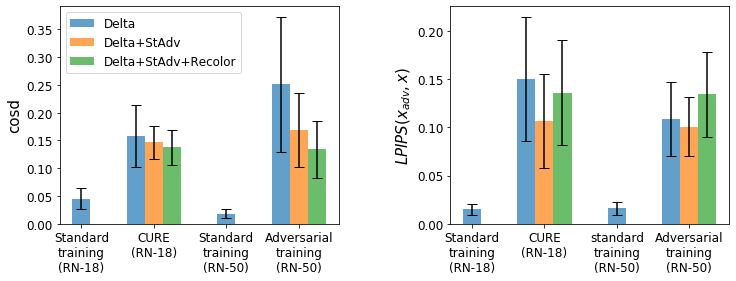

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([1.1,1.9])
################
ax[0].bar(sorted([0.7] + list(x_s - 0.1) + [1.5]), 
           [np.mean(spr_to_target_map["standard"]["add"]),
            np.mean(spr_to_target_map["CURE"]["add"]),
            np.mean(spr_to_target_map["standard_RN50"]["add"]),
            np.mean(spr_to_target_map["adv_train_RN50"]["add"])], 
            yerr=[spr_errors["standard"]["add"], spr_errors["CURE"]["add"],
                  spr_errors["standard_RN50"]["add"], spr_errors["adv_train_RN50"]["add"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=5)

# ax[0].bar(x_s - 0.075, 
#            [np.mean(spr_to_target_map["CURE"]["add_recolor"]),
#             np.mean(spr_to_target_map["adv_train_RN50"]["add_recolor"])], 
#             yerr=[spr_errors["CURE"]["add_recolor"], spr_errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="Delta+Recolor", 
#             align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.0, 
           [np.mean(spr_to_target_map["CURE"]["add_stadv"]),
            np.mean(spr_to_target_map["adv_train_RN50"]["add_stadv"])], 
            yerr=[spr_errors["CURE"]["add_stadv"], spr_errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.1, 
           [np.mean(spr_to_target_map["CURE"]["add_stadv_recolor"]),
            np.mean(spr_to_target_map["adv_train_RN50"]["add_stadv_recolor"])], 
            yerr=[spr_errors["CURE"]["add_stadv_recolor"], spr_errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].set_xticks([0.7, 1.1, 1.5, 1.9])
ax[0].set_xticklabels(["Standard\ntraining\n(RN-18)", "CURE\n(RN-18)", "Standard\ntraining\n(RN-50)", "Adversarial\ntraining\n(RN-50)"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_ylabel("cosd", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=3e-6)

ax[1].bar(sorted([0.7] + list(x_s - 0.1) + [1.5]), 
           [np.mean(lpips_to_original_image["standard"]["add"]),
            np.mean(lpips_to_original_image["CURE"]["add"]),
            np.mean(lpips_to_original_image["standard_RN50"]["add"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add"])], 
            yerr=[lpips_errors["standard"]["add"], lpips_errors["CURE"]["add"],
                  lpips_errors["standard_RN50"]["add"], lpips_errors["adv_train_RN50"]["add"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

# ax[1].bar(x_s - 0.075, 
#            [np.mean(lpips_to_original_image["CURE"]["add_recolor"]),
#             np.mean(lpips_to_original_image["adv_train_RN50"]["add_recolor"])],
#             yerr=[lpips_errors["CURE"]["add_recolor"], lpips_errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="add_recolor",
#             align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.0, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv"])],
            yerr=[lpips_errors["CURE"]["add_stadv"], lpips_errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.1, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv_recolor"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv_recolor"])],
            yerr=[lpips_errors["CURE"]["add_stadv_recolor"], lpips_errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks([0.7, 1.1, 1.5, 1.9])
ax[1].set_xticklabels(["Standard\ntraining\n(RN-18)", "CURE\n(RN-18)", "standard\ntraining\n(RN-50)", "Adversarial\ntraining\n(RN-50)"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_attacks_cosd_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [24]:
print(np.mean(spr_to_target_map["standard"]["add"]), np.std(spr_to_target_map["standard"]["add"]))

0.0469906863413359 0.019722719139295113


## Batch results

In [42]:
cosd_to_target_map = {"add": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}, 
         "add_stadv": {"standard":[], "CURE": [], "adv_train": [], "SSR": []},
         "add_stadv_recolor": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}}

cosd_to_org_map = {"add": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}, 
         "add_stadv": {"standard":[], "CURE": [], "adv_train": [], "SSR": []},
         "add_stadv_recolor": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}}

lpips_to_original_image = {"add": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}, 
         "add_stadv": {"standard":[], "CURE": [], "adv_train": [], "SSR": []},
         "add_stadv_recolor": {"standard":[], "CURE": [], "adv_train": [], "SSR": []}}

for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["standard", "CURE", "adv_train"]:
        for folder in os.listdir("../examples/ad_hoc_results_batch/"+att+"/"+method+"/"):
            with open("../examples/ad_hoc_results_batch/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
#                 if int(folder.split("_")[1]) > 5:
#                     continue
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    lpips_to_original_image[att][method].append(lines[-1].strip().split(" ")[2:])
                    for l in lines[::-1]:
                        if l.startswith("Final cosd vs target"):
                            cosd_to_target_map[att][method].append(l.strip().split(" ")[4:])
                            break
                    for l in lines[::-1]:
                        if l.startswith("Final cosd vs org"):
                            cosd_to_org_map[att][method].append(l.strip().split(" ")[4:])
                            break

In [43]:
import itertools
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["standard", "CURE", "adv_train"]:
        c = itertools.chain(*cosd_to_target_map[att][method])
        cosd_to_target_map[att][method] = list(c)
        ################
        c = itertools.chain(*cosd_to_org_map[att][method])
        cosd_to_org_map[att][method] = list(c)
        ################
        c = itertools.chain(*lpips_to_original_image[att][method])
        lpips_to_original_image[att][method] = list(c)

In [44]:
# convert to float
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["standard", "CURE", "adv_train"]:
        cosd_to_target_map[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          cosd_to_target_map[att][method]]
        cosd_to_org_map[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          cosd_to_org_map[att][method]]
        lpips_to_original_image[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          lpips_to_original_image[att][method]]

In [47]:
len(cosd_to_target_map["add_stadv"]["standard"])

907

In [48]:
len(cosd_to_org_map["add"]["adv_train"])

813

### viz

In [49]:
cosd_to_target_errors = {}
for k, v in cosd_to_target_map.items():
    cosd_to_target_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [50]:
cosd_to_org_errors = {}
for k, v in cosd_to_org_map.items():
    cosd_to_org_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [51]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

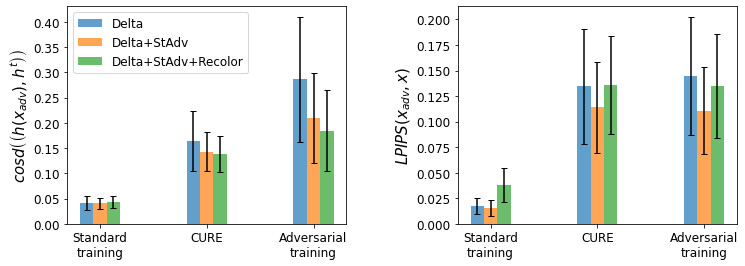

In [54]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([0.8, 1.6, 2.4])
ax[0].bar(x_s -0.1, 
           [np.mean(cosd_to_target_map["add"]["standard"]),
            np.mean(cosd_to_target_map["add"]["CURE"]), 
            np.mean(cosd_to_target_map["add"]["adv_train"])], 
            yerr=[cosd_to_target_errors["add"]["standard"], cosd_to_target_errors["add"]["CURE"], cosd_to_target_errors["add"]["adv_train"]], 
            width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[0].bar(x_s + 0.0, 
           [np.mean(cosd_to_target_map["add_stadv"]["standard"]),
            np.mean(cosd_to_target_map["add_stadv"]["CURE"]),
            np.mean(cosd_to_target_map["add_stadv"]["adv_train"])], 
            yerr=[cosd_to_target_errors["add_stadv"]["standard"], cosd_to_target_errors["add_stadv"]["CURE"], 
                  cosd_to_target_errors["add_stadv"]["adv_train"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].bar(x_s + 0.1, 
           [np.mean(cosd_to_target_map["add_stadv_recolor"]["standard"]),
            np.mean(cosd_to_target_map["add_stadv_recolor"]["CURE"]),
            np.mean(cosd_to_target_map["add_stadv_recolor"]["adv_train"])], 
            yerr=[cosd_to_target_errors["add_stadv_recolor"]["standard"], cosd_to_target_errors["add_stadv_recolor"]["CURE"], 
                  cosd_to_target_errors["add_stadv_recolor"]["adv_train"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["Standard\ntraining", "CURE", "Adversarial\ntraining"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_ylabel(r"$cosd\left( \left( h(x_{adv}), h^t \right) \right)$", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
# ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=7e-10)

ax[1].bar(x_s - 0.1, 
           [np.mean(lpips_to_original_image["add"]["standard"]),
            np.mean(lpips_to_original_image["add"]["CURE"]), 
            np.mean(lpips_to_original_image["add"]["adv_train"])*1.3], 
            yerr=[lpips_errors["add"]["standard"], lpips_errors["add"]["CURE"], lpips_errors["add"]["adv_train"]], 
            width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[1].bar(x_s + 0.0, 
           [np.mean(lpips_to_original_image["add_stadv"]["standard"]),
            np.mean(lpips_to_original_image["add_stadv"]["CURE"]),
            np.mean(lpips_to_original_image["add_stadv"]["adv_train"])],
            yerr=[lpips_errors["add_stadv"]["standard"], lpips_errors["add_stadv"]["CURE"], 
                  lpips_errors["add_stadv"]["adv_train"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].bar(x_s + 0.1, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["standard"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["CURE"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["adv_train"])],
            yerr=[lpips_errors["add_stadv_recolor"]["standard"], lpips_errors["add_stadv_recolor"]["CURE"], 
                  lpips_errors["add_stadv_recolor"]["adv_train"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["Standard\ntraining", "CURE", "Adversarial\ntraining"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_attacks_cosd_cifar_target.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [18]:
np.mean(lpips_to_original_image["add"]["standard"])

0.022206049661326686

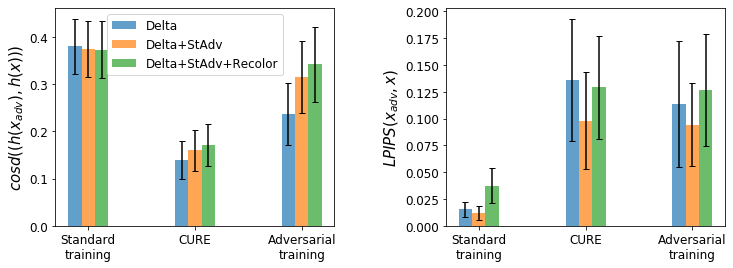

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([0.8, 1.6, 2.4])
ax[0].bar(x_s -0.1, 
           [np.mean(cosd_to_org_map["add"]["standard"]),
            np.mean(cosd_to_org_map["add"]["CURE"]), 
            np.mean(cosd_to_org_map["add"]["adv_train"])], 
            yerr=[cosd_to_org_errors["add"]["standard"], cosd_to_org_errors["add"]["CURE"], cosd_to_org_errors["add"]["adv_train"],], 
            width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[0].bar(x_s + 0.0, 
           [np.mean(cosd_to_org_map["add_stadv"]["standard"]),
            np.mean(cosd_to_org_map["add_stadv"]["CURE"]),
            np.mean(cosd_to_org_map["add_stadv"]["adv_train"])], 
            yerr=[cosd_to_org_errors["add_stadv"]["standard"], cosd_to_org_errors["add_stadv"]["CURE"], 
                  cosd_to_org_errors["add_stadv"]["adv_train"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].bar(x_s + 0.1, 
           [np.mean(cosd_to_org_map["add_stadv_recolor"]["standard"]),
            np.mean(cosd_to_org_map["add_stadv_recolor"]["CURE"]),
            np.mean(cosd_to_org_map["add_stadv_recolor"]["adv_train"])], 
            yerr=[cosd_to_org_errors["add_stadv_recolor"]["standard"], cosd_to_org_errors["add_stadv_recolor"]["CURE"], 
                  cosd_to_org_errors["add_stadv_recolor"]["adv_train"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["Standard\ntraining", "CURE", "Adversarial\ntraining"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_ylabel(r"$cosd\left( \left( h(x_{adv}), h(x) \right) \right)$", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
# ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=7e-10)

ax[1].bar(x_s - 0.1, 
           [np.mean(lpips_to_original_image["add"]["standard"]),
            np.mean(lpips_to_original_image["add"]["CURE"]), 
            np.mean(lpips_to_original_image["add"]["adv_train"])], 
            yerr=[lpips_errors["add"]["standard"], lpips_errors["add"]["CURE"], lpips_errors["add"]["adv_train"]], 
            width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[1].bar(x_s + 0.0, 
           [np.mean(lpips_to_original_image["add_stadv"]["standard"]),
            np.mean(lpips_to_original_image["add_stadv"]["CURE"]),
            np.mean(lpips_to_original_image["add_stadv"]["adv_train"])],
            yerr=[lpips_errors["add_stadv"]["standard"], lpips_errors["add_stadv"]["CURE"], 
                  lpips_errors["add_stadv"]["adv_train"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].bar(x_s + 0.1, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["standard"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["CURE"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["adv_train"])],
            yerr=[lpips_errors["add_stadv_recolor"]["standard"], lpips_errors["add_stadv_recolor"]["CURE"], 
                  lpips_errors["add_stadv_recolor"]["adv_train"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["Standard\ntraining", "CURE", "Adversarial\ntraining"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_attacks_cosd_cifar_org.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### $\ell_1$ attack

In [12]:
for method in ["CURE", "adv_train_RN50"]:
    for att in ["add_l1"]:
        mse_to_target_map[method][att] = []
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                for l in lines[::-1]:
                    if l.startswith("expl loss:"):
                        mse_to_target_map[method][att].append(float(l.strip().split(" ")[-1]))
                        break

In [14]:
for method in ["CURE", "adv_train_RN50"]:
    for att in ["add_l1"]:
        lpips_to_original_image[method][att] = []
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
            lpips_to_original_image[method][att].append(float(lines[-2].strip().split(" ")[-1]))

In [17]:
errors["CURE"]["add_l1"] = np.std(mse_to_target_map["CURE"]["add_l1"])
errors["adv_train_RN50"]["add_l1"] = np.std(mse_to_target_map["adv_train_RN50"]["add_l1"])
####
lpips_errors["CURE"]["add_l1"] = np.std(lpips_to_original_image["CURE"]["add_l1"])
lpips_errors["adv_train_RN50"]["add_l1"] = np.std(lpips_to_original_image["adv_train_RN50"]["add_l1"])

Text(0, 0.5, '$LPIPS(x_{adv}, x)$')

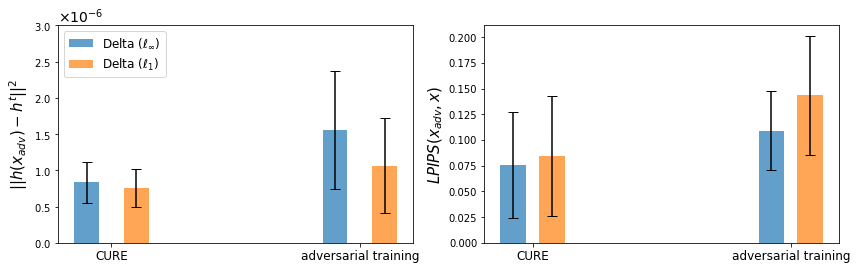

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2])

ax[0].bar(x_s - 0.1, 
           [np.mean(mse_to_target_map["CURE"]["add"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add"])], 
            yerr=[errors["CURE"]["add"], errors["adv_train_RN50"]["add"]], width=0.1, label=r"Delta ($\ell_{\infty}$)", 
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.1, 
           [np.mean(mse_to_target_map["CURE"]["add_l1"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_l1"])], 
            yerr=[errors["CURE"]["add_l1"], errors["adv_train_RN50"]["add_l1"]], width=0.1, label="Delta ($\ell_1$)",
            align='center', alpha=0.7, ecolor='black', capsize=5)


ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=3e-6)


ax[1].bar(x_s - 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add"])],
            yerr=[lpips_errors["CURE"]["add"], lpips_errors["adv_train_RN50"]["add"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add_l1"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_l1"])],
            yerr=[lpips_errors["CURE"]["add_l1"], lpips_errors["adv_train_RN50"]["add_l1"]], width=0.1, label="add_l1",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
# plt.savefig("compare_attacks_mse_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);